In [2]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%b %d, %Y')
# loading data for Argentina
argentina_stock = pd.read_csv('data/argentina.csv',sep=',', parse_dates=['Date'], date_parser=dateparse).fillna(0)
argentina_stock['Vol.'] = (argentina_stock['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) * argentina_stock['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
argentina_stock

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_67040/1820159528.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%b %d, %Y')


,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31,85.15,86.50,88.10,85.15,564300.0,-1.10%
1,2021-03-30,86.10,85.15,86.75,84.60,141400.0,1.29%
2,2021-03-29,85.00,80.00,86.00,79.00,371220.0,3.85%
3,2021-03-26,81.85,84.00,84.60,80.70,462550.0,-2.09%
4,2021-03-25,83.60,85.20,87.30,82.10,389780.0,-3.13%
...,...,...,...,...,...,...,...
295,2020-01-08,46.50,47.50,47.50,46.00,1180000.0,-2.31%
296,2020-01-07,47.60,48.35,49.00,46.90,901950.0,-1.86%
297,2020-01-06,48.50,48.40,48.70,47.00,719240.0,-0.61%
298,2020-01-03,48.80,48.25,49.45,46.50,595360.0,1.14%


In [4]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Price'] = min_max_scaler.fit_transform(df.Price.values.reshape(-1,1))
    return df

In [5]:
normalized_stock = normalize_data(argentina_stock)

In [6]:
normalized_stock

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31,0.932916,0.956140,0.964717,0.969891,564300.0,-1.10%
1,2021-03-30,0.949911,0.932456,0.939647,0.959854,141400.0,1.29%
2,2021-03-29,0.930233,0.842105,0.925720,0.857664,371220.0,3.85%
3,2021-03-26,0.873882,0.912281,0.899721,0.888686,462550.0,-2.09%
4,2021-03-25,0.905188,0.933333,0.949861,0.914234,389780.0,-3.13%
...,...,...,...,...,...,...,...
295,2020-01-08,0.241503,0.271930,0.210771,0.255474,1180000.0,-2.31%
296,2020-01-07,0.261181,0.286842,0.238626,0.271898,901950.0,-1.86%
297,2020-01-06,0.277281,0.287719,0.233055,0.273723,719240.0,-0.61%
298,2020-01-03,0.282648,0.285088,0.246982,0.264599,595360.0,1.14%


In [7]:
start_date = '2021-01-01' 
end_date = '2021-03-31'
test = normalized_stock.loc[(normalized_stock['Date'] >= start_date) & (normalized_stock['Date'] <= end_date)]
remaining = normalized_stock[~normalized_stock.index.isin(test.index)]
# Split the data into train and validation sets
train_data, val_data = train_test_split(remaining, test_size=0.1, random_state=42)

In [8]:
x_train = train_data[['Date','Price','Open','High','Low']]
x_train['Date'] = pd.to_datetime(train_data['Date'])
x_train.set_index('Date', inplace=True)

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_67040/1135334496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Date'] = pd.to_datetime(train_data['Date'])


In [9]:
val_train = val_data[['Date','Price','Open','High','Low']]
val_train['Date'] = pd.to_datetime(val_data['Date'])
val_train.set_index('Date', inplace=True)

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_67040/460070084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_train['Date'] = pd.to_datetime(val_data['Date'])


In [10]:
y_test = test[['Date','Price','Open','High','Low']]
y_test['Date'] = pd.to_datetime(y_test['Date'])
y_test.set_index('Date', inplace=True)

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_67040/1497887966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Date'] = pd.to_datetime(y_test['Date'])


In [11]:
val_train

,Price,Open,High,Low
Date,,,,
2020-11-19,0.812165,0.861404,0.851439,0.836679
2020-12-18,0.876565,0.894737,0.888579,0.881387
2020-08-11,0.434705,0.454386,0.415042,0.451642
2020-07-20,0.349732,0.345614,0.315692,0.352190
2020-07-27,0.407871,0.456140,0.416899,0.428832
2020-04-15,0.243292,0.200877,0.204271,0.191606
2020-01-10,0.270125,0.289474,0.247911,0.286496
2020-08-21,0.462433,0.470175,0.471681,0.450730
2020-12-15,0.840787,0.850877,0.851439,0.857664


In [49]:
X_train = x_train[['Open','High','Low']]
Y_train = x_train['Price']
X_val = val_train[['Open','High','Low']]
Y_val = val_train['Price']
X_test = y_test[['Open','High','Low']]
Y_test = y_test['Price']

In [50]:
print('X_train.shape = ',X_train.shape)
print('X_val.shape = ',X_val.shape)
print('X_test.shape = ',X_test.shape)
print('X_test.shape = ',Y_test.shape)

X_train.shape =  (216, 3)
X_val.shape =  (24, 3)
X_test.shape =  (60, 3)
X_test.shape =  (60,)


In [52]:
# Reshape the input data for the LSTM model
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
# Reshape the input data for the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [53]:
# Define the model
model = keras.Sequential()
model.add(layers.GRU(64, input_shape=(3, 1), return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(32, return_sequences=False))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_val, Y_val))

Epoch 1/50
14/14 [==============================] - 2s 37ms/step - loss: 0.1475 - val_loss: 0.0691
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 0.0294 - val_loss: 0.0168
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0160 - val_loss: 0.0135
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 6.5720e-04
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 9.5602e-04
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 9.6401e-04
Epoch 10/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 5.6934e-04
Ep

In [55]:
# Evaluate the model on the test set
mse = model.evaluate(X_test, Y_test)
print('Test MSE:', mse)

2/2 [==============================] - 0s 2ms/step - loss: 8.3810e-04
Test MSE: 0.0008380982908420265


In [58]:
predicted_values = model.predict(X_test)

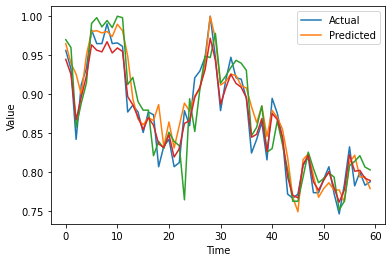

In [59]:
plt.plot(X_test[:, :, 0])

# Plot the predicted values
plt.plot(predicted_values)

# Add legend and axis labels
plt.legend(['Actual', 'Predicted'])
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()